Follow the tutorial material from Kaggle

In [1]:
import numpy as np
import pandas as pd
import re
from bs4 import BeautifulSoup
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt
import warnings

warnings.filterwarnings("ignore")
%matplotlib inline

# Read data

In [2]:
train = pd.read_csv('./data/labeledTrainData.tsv', delimiter='\t', quoting=3)
test = pd.read_csv('./data/testData.tsv', delimiter='\t', quoting=3)

# get the number of training and test examples
n_train = len(train)
n_test = len(test)

print('Training set shape\t', train.shape)
print('Testing set shape\t', test.shape)
print('Positive vs. Negative:\t', len(train[train['sentiment'] == 1]), len(train[train['sentiment'] != 1]))

Training set shape	 (25000, 3)
Testing set shape	 (25000, 2)
Positive vs. Negative:	 12500 12500


In [3]:
train.head()

,id,sentiment,review
0,"""5814_8""",1,"""With all this stuff going down at the moment ..."
1,"""2381_9""",1,"""\""The Classic War of the Worlds\"" by Timothy ..."
2,"""7759_3""",0,"""The film starts with a manager (Nicholas Bell..."
3,"""3630_4""",0,"""It must be assumed that those who praised thi..."
4,"""9495_8""",1,"""Superbly trashy and wondrously unpretentious ..."


# Data Cleaning

In [4]:
def review2words(review):
    """ function to convert input review into string of words """
    # Remove HTML
    review_text = BeautifulSoup(review, 'lxml').get_text() 

    # Remove non-letters        
    letters_only = re.sub("[^a-zA-Z]", " ", review_text) 

    # Convert to lower case, split into individual words
    words = letters_only.lower().split()                             

    # Join the words and return the result.
    return(" ".join(words))   

In [5]:
# get train label
train_y = train['sentiment'].values

# transform reviews into words list
train_review = list(map(review2words, train['review']))
test_review = list(map(review2words, test['review']))

# combine train and test reviews
all_review = train_review + test_review

In [6]:
# perform TF-IDF transformation
vectorizer = TfidfVectorizer(min_df=3, analyzer="word", strip_accents='unicode',
                             stop_words='english', max_features=5000, ngram_range=(1, 1)) 

# fit and transform the data
all_features = vectorizer.fit_transform(all_review)

# trainsform into array
train_features = all_features[:n_train, :].toarray()
test_features = all_features[n_train:, :].toarray()

# Random Forest Model

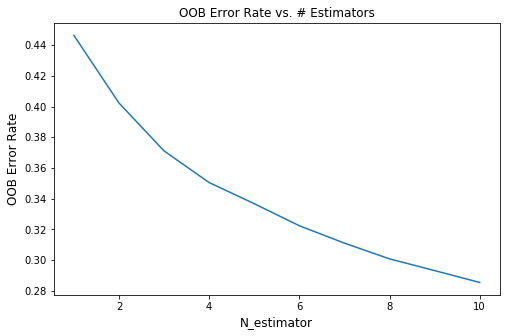

In [7]:
# exploratory study to determine the best number of estimators
n_estimators = 500
forest = RandomForestClassifier(warm_start=True, oob_score=True, random_state=2017, 
                                n_jobs=-1, max_features='auto')

oob = []
for i in range(1, n_estimators + 1):
    forest.set_params(n_estimators=i)
    forest.fit(train_features, train_y)
    oob.append(forest.oob_score_)

# plot the curve of OOB error rate
fig, ax = plt.subplots(figsize=(8, 5))
ax.plot(range(1, len(oob) + 1), 1 - np.array(oob), '-')
ax.set_xlabel('N_estimator', fontsize=12)
ax.set_ylabel('OOB Error Rate', fontsize=12)
ax.set_title('OOB Error Rate vs. # Estimators')
plt.show()

In [8]:
# # Initialize a Random Forest classifier
# forest = RandomForestClassifier(n_estimators=300, n_jobs=-1, random_state=2017, 
#                                 oob_score=True, max_features='auto') 
# 
# # Fit the forest to the training set
# forest.fit(train_features, train_y)

In [9]:
# find all the words used
words = vectorizer.get_feature_names()
importance = forest.feature_importances_

# sort to get the most importance words
tmp = list(zip(importance, words))
tmp.sort(reverse=True)
words_sorted = [word for (_, word) in tmp]

In [10]:
# make predictions
train_pred = forest.predict_proba(train_features)[:, 1]
test_pred = forest.predict_proba(test_features)[:, 1]

# save prediction into local files
output = pd.DataFrame(data={"id": test["id"], "sentiment": test_pred})
output.to_csv("./result/random_forest.csv", index=False, quoting=3)

# get the AUC score
print('AUC\t', roc_auc_score(train_y, train_pred))

AUC	 0.9997738432


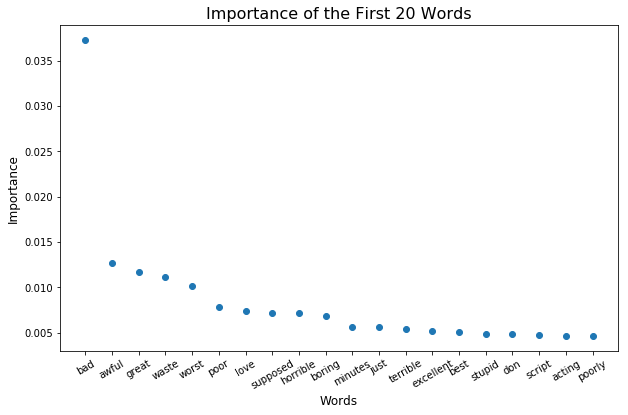

In [11]:
# plot of importance vs. words
N = 20
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(range(1, N + 1), sorted(importance, reverse=True)[:N], 'o')
ax.set_title('Importance of the First {0} Words'.format(N), fontsize=16)
ax.set_xlabel('Words', fontsize=12)
ax.set_ylabel('Importance', fontsize=12)
ax.set_xticks(range(1, N + 1))
ax.set_xticklabels(words_sorted[:N], rotation=30, fontsize=10)
plt.show()